### Lymphography Dataset
Zwitter, M. & Soklic, M. (1988). Lymphography [Dataset]. UCI Machine Learning Repository. https://doi.org/10.24432/C54598.

In [1]:
import pandas as pd
from edm_cif import EDM_CIF

df = pd.read_csv('lymphography.csv', sep=',')
df_class = df['class']
df.drop('class', axis=1, inplace=True)
for c in df.columns:
    df[c] = df[c].fillna(df[c].mode()[0])

df.head()

,lymphatics,block of affere,bl. of lymph,bl. of lymph.1,by pass,extravasates,regeneration of,early uptake in,lym.nodes dimin,lym.nodes enlar,changes in lym.,defect in node,changes in node,changes in stru,special forms,dislocation,exclusion of no,no. of nodes in
0,4,2,1,1,1,1,1,2,1,2,2,2,4,8,1,1,2,2
1,3,2,1,1,2,2,1,2,1,3,3,2,3,4,2,2,2,2
2,3,2,2,2,2,2,2,2,1,4,3,3,4,8,3,2,2,7
3,3,1,1,1,1,2,1,2,1,3,3,4,4,4,3,1,2,6
4,3,1,1,1,1,1,1,1,1,2,2,4,3,5,1,2,2,1


In [2]:
df_class.value_counts()

class
2    81
3    61
4     4
1     2
Name: count, dtype: int64

In [3]:
alg = EDM_CIF(n_estimators=300, max_features=5, max_samples=500, m=2, contamination=0.04)
labels = alg.fit_predict(df)

df['class'] = df_class
df['labels'] = labels

result = df.groupby(['labels', 'class']).size().unstack(fill_value=0)
result

class,1,2,3,4
labels,,,,
-1,2,1,0,3
1,0,80,61,1


In [4]:
alg.predict_proba(df)

array([0.26920024, 0.20584569, 0.52958881, 0.34604386, 0.13871393,
       0.36614088, 0.12861353, 0.33528194, 0.1993684 , 0.19376957,
       0.36972295, 0.18099551, 0.30605527, 0.32462629, 0.88245022,
       0.05439089, 0.20275448, 0.20296644, 0.14637772, 0.24992045,
       0.16902917, 0.41116704, 0.28075142, 0.25047222, 0.49271081,
       0.17881269, 0.23357271, 0.15551225, 0.13173631, 0.16500257,
       0.30345852, 0.08897185, 0.23448117, 0.35643444, 0.13187286,
       0.20087365, 0.80738749, 0.24806612, 0.12316731, 0.34975535,
       0.09632122, 0.4825018 , 0.32545996, 0.36143581, 0.62534446,
       0.0487633 , 0.23181625, 0.46704498, 0.31289418, 0.15402564,
       0.4332673 , 0.21834792, 0.25911409, 0.37812234, 0.31184439,
       0.20418224, 0.12496847, 0.32583342, 0.61981831, 0.14366491,
       0.38716593, 0.32119513, 0.30332096, 0.36143535, 0.08540369,
       0.49497154, 0.31970826, 0.35246128, 0.24502375, 0.31808314,
       0.0796442 , 0.32510355, 0.44872441, 0.35671261, 0.29654

### Costrastive Outlier Score (COS)

In [5]:
from contrastive_outlier_score import contrastive_outlier_score, one_hot_encoding

cos = contrastive_outlier_score(df=df, labels=labels, metric='hamming', strategy='n_closest', n=20)
print(cos)
cos = contrastive_outlier_score(df=df, labels=labels, metric='hamming', strategy='n_closest', n=100)
print(cos)

0.5092
0.6148


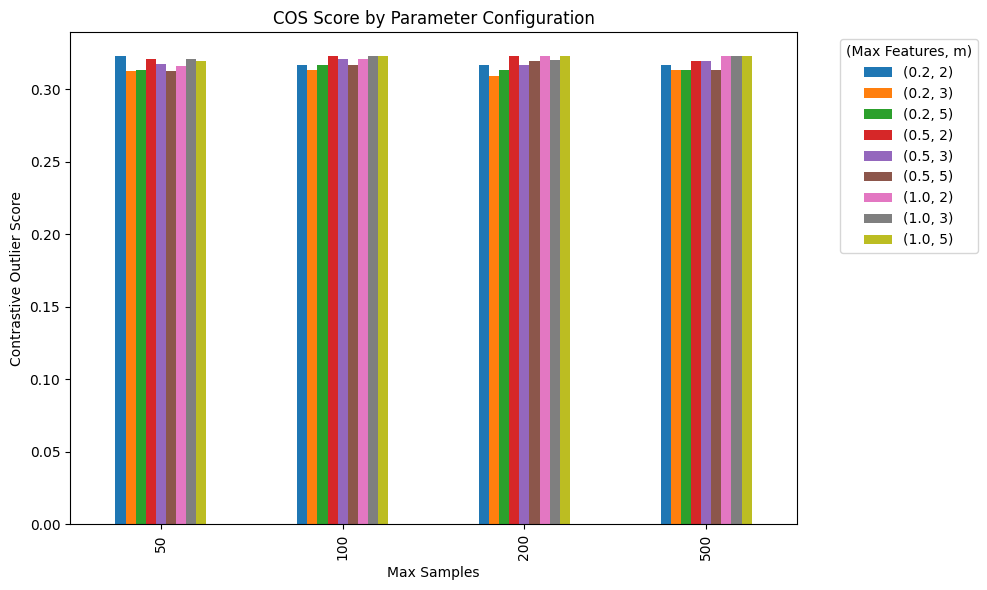

In [7]:
import matplotlib.pyplot as plt
from itertools import product
import warnings
from collections import Counter
warnings.filterwarnings('ignore')

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_samples': [50, 100, 200, 500],
    'max_features': [0.2, 0.5, 1.0],
    'm': [2, 3, 5]
}

results = []
for n_estimators, max_samples, max_features, m in product(param_grid['n_estimators'],
                                            param_grid['max_samples'],
                                            param_grid['max_features'],
                                            param_grid['m']):

    alg = EDM_CIF(n_estimators=n_estimators, max_features=max_features, max_samples=max_samples, m=m, contamination=0.04)
    labels = alg.fit_predict(df)

    cos_score = contrastive_outlier_score(one_hot_encoding(df), labels, metric='hamming', strategy='n_closest', n=20)
    results.append({
        'max_samples': max_samples,
        'max_features': max_features,
        'm': m,
        'COS': cos_score
    })


results_df = pd.DataFrame(results)
pivot_table = results_df.pivot_table(values='COS', index='max_samples', columns=['max_features', 'm'])

fig, ax = plt.subplots(figsize=(10, 6))
pivot_table.plot(kind='bar', ax=ax)
ax.set_title('COS Score by Parameter Configuration')
ax.set_ylabel('Contrastive Outlier Score')
ax.set_xlabel('Max Samples')
ax.legend(title='(Max Features, m)', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()